## Introduction to bandit problems and algorithms

In [9]:
%matplotlib inline
from matplotlib.pyplot import *
from math import *
from numpy import *
from numpy.random import *
from scipy.misc import *
from scipy.stats import *

In the sequel we consider the stochastic bandit problem with only two actions $0$ and $1$. We assume that their rewards are Bernoulli random variables with parameters $\mu_0 = 0.6$ and $\mu_1 = 0.4$ (so that action $0$ is optimal, but we have to learn it from experience!).

### Simulation of Bernoulli random variables:

In [10]:
binomial(n=10,p=0.5,size=46)

array([7, 4, 7, 5, 4, 5, 4, 6, 5, 3, 3, 5, 6, 4, 6, 5, 6, 4, 7, 4, 6, 5,
       9, 5, 9, 7, 5, 4, 4, 7, 6, 4, 3, 8, 5, 3, 6, 5, 5, 5, 5, 4, 4, 7,
       5, 6])

In [11]:
binomial(n=1,p=0.5,size=5)

array([0, 1, 1, 0, 1])

### Notation:
- The arm played by the algorithm at time $t$ is denoted by $I_t$.
- The reward of arm $a$ at time $t$ is $g_t(a)$.
- We write $\hat{\mu}_t(a)$ for the average of the rewards obtained from arm $a \in \{0,1\}$ between iterations $1$ and $t$.
- We also write $T_a(t)$ for the number of times arm $a$ was played up to iteration $t$.
- In particular, we have
$$\hat{\mu}_t(a) = \frac{1}{T_a(t)} \sum_{k=1}^t g_k(a) \mathbb{1}_{I_k = a}$$

## Why stopping exploring is a bad idea if we do not know the time horizon.

The "Explore-Then-Commit" algorithm proceeds as follows:
- alternatively play actions $0$ and $1$ from iteration $t=1$ up to iteration $t=\tau$
- determine the empirically best arm
$$A \in \rm{argmax}_{a \in \{0,1\}} \hat{\mu}_{\tau}(a)$$
- play arm A forever.

Questions: Understand the code below and
1. Show that, if $\tau$ is fixed, then the (expected) regret after $T$ rounds grows linearly with $T$ when $T \to +\infty$ (which is very bad). Explain the title of this section.
2. Compare the above conclusion with the theoretical result stating that the regret is only logarithmic in $T$ provided $m$ is chosen roughly like $m \approx \log(T \Delta^2)/\Delta^2$, where $\Delta = |\mu_0 - \mu_1|$.
3. Try different values for the parameters $m$, $\mu_0$, and $\mu_1$. Interpret the results in terms of exploration/exploitation.

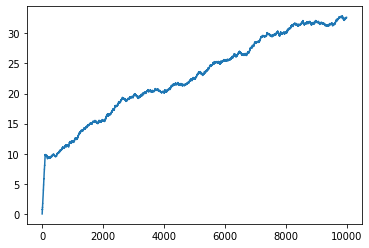

In [12]:
m = 50
tau = 2*m # size of exploration phase
T = 10**4  # total number of rounds
MC = 200    # number of Monte-Carlo experiments
mu = [0.6,0.4]
# Try also:
#mu = [0.8,0.2]
#mu = [0.51,0.49]
mustar = max(mu)

avregret = zeros(T)  # will contain an estimate of the (expected) regret R_t for all t<=T

for experiment in range(MC):
    regret = 0
    muhat = [0,0] # after exploration phase, will contain estimates of expected rewards of arms 0 and 1
    # exploration phase
    for t in range(tau):
        A = t % 2 # we choose 0 or 1 alternatively
        r = binomial(1,mu[A]) # observed reward
        muhat[A] += r/m
        regret += mustar - r
        avregret[t] += regret/MC # updates the estimate of the expected regret at time t
    # exploitation phase: play best arm forever
    A = argmax(muhat)
    for t in range(tau,T):
        r = binomial(1,mu[A]) # observed reward
        regret += mustar - r
        avregret[t] += regret/MC # update the estimate of the (expected) regret at time t 
    
plot(avregret)

## The $\epsilon$-greedy algorithm.

The "$\epsilon$-greedy algorithm" proceeds as follows:
- For the first two iterations: play actions $0$ and $1$ once
- At each iteration $t=3,4,5,\ldots$,
    - with probability $1-\epsilon_t$, play the empirically best arm
    - with probability $\epsilon_t$, play action $0$ or $1$ uniformly at random

Questions: Implement the algorithm and
1. Show that, if $\epsilon_t = \min \left\{\frac{c}{t},1\right\}$ with a large enough constant $c>0$, then the (expected) regret after $T$ rounds only grows logarithmically when $T \to +\infty$.
2. What happens if we choose $\epsilon_t=\epsilon$ constant over time? or too small a value for $c$? (interpret the results in terms of exploration/exploitation)
3. What is the main advantage of $\epsilon$-greedy compared to Explore-Then-Commit? Which drawback remains?

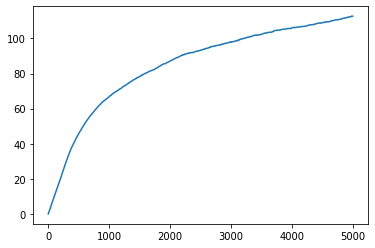

In [13]:
T = 5*10**3  # total number of rounds
MC = 500    # number of Monte-Carlo experiments
mu = [0.6,0.4]
# Try also:
#mu = [0.8,0.2]
#mu = [0.51,0.49]
mustar = max(mu)

# exploration parameter of the algorithm: epsilon_t = min(c/t,1) where
c = 6*2/abs(mu[0]-mu[1])**2
# (the choice of any c > 5*K/\Delta^2 is guaranteed by the theory to yield logarithmic regret)

avregret = zeros(T)  # will contain an estimate of the (expected) regret R_t for all t<=T

for experiment in range(MC):
    regret = 0
    muhat = [0,0] # estimates of expected rewards for arms 0 and 1
    armcounts = [0,0] # number of draws for arms 0 and 1
    # initialization
    for t in range(2):
        A = t % 2 # we choose 0 or 1 alternatively
        r = binomial(1,mu[A]) # observed reward
        armcounts[A] += 1
        muhat[A] += r
        regret += mustar - r
        avregret[t] += regret/MC # updates the estimate of the expected regret at time t
    # exploration-exploitation phase: play epsilon-greedy
    for t in range(2,T):
        epsilon = min(c/(t+1),1) # the (minor) shift by +1 is because time starts at t=0 on Python
        z = binomial(1,epsilon) # flip a biased coin (a result of 1 means we explore)
        if z==1:
            A = binomial(1,0.5) # A = 0 or 1 with probability 0.5
        else:
            A = argmax(muhat) # choose the empirically best arm (given the past observations)
        r = binomial(1,mu[A]) # observed reward
        armcounts[A] += 1
        muhat[A] += (r-muhat[A])/armcounts[A]
        regret += mustar - r
        avregret[t] += regret/MC # update the estimate of the (expected) regret at time t 
    
plot(avregret)

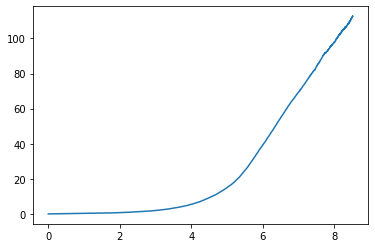

In [14]:
plot(log(arange(1,T+1)),avregret)

## The UCB algorithm.

The UCB-algorithm proceeds as follows:
- For the first two iterations: play actions $0$ and $1$ once.
- At each iteration $t=3,4,5,\ldots$, play the arm that maximizes the Upper Confidence Bound:
$$I_t \in \rm{argmax}_{a \in \{0,1\}} \left\{\hat{\mu}_{t-1}(a) + \sqrt{\frac{2 \log(t)}{T_a(t-1)}} \;\right\}$$
   
Questions: Implement the algorithm and
1. Show that the (expected) regret after $T$ rounds also grows logarithmically when $T \to +\infty$.
2. Compare UCB with the first two algorithms in terms of performances and of required prior knowledge.

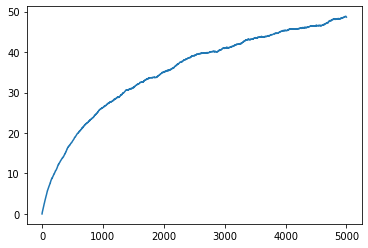

In [15]:
T = 5*10**3  # total number of rounds
MC = 500    # number of Monte-Carlo experiments
mu = [0.6,0.4]
# Try also:
#mu = [0.8,0.2]
#mu = [0.51,0.49]
mustar = max(mu)

## NO PROBLEM-DEPENDENT PARAMETER HERE !
# (NB: we could optimize the sqrt(2) constant, but at least sqrt(2) is universal.)

avregret = zeros(T)  # will contain an estimate of the (expected) regret R_t for all t<=T

for experiment in range(MC):
    regret = 0
    muhat = [0,0] # after exploration phase, will contain estimates of expected rewards of arms 0 and 1
    armcounts = [0,0] # number of draws for each arm
    # initialization
    for t in range(2):
        A = t % 2 # we choose 0 or 1 alternatively
        r = binomial(1,mu[A]) # observed reward
        armcounts[A] += 1
        muhat[A] += r
        regret += mustar - r
        avregret[t] += regret/MC # updates the estimate of the expected regret at time t
    # exploration-exploitation phase: play UCB
    for t in range(2,T):
        A = argmax(muhat + sqrt(2*log(t+1)/armcounts)) # choose arm with highest Upper Confidence Bound
        r = binomial(1,mu[A]) # observed reward
        armcounts[A] += 1
        muhat[A] += (r-muhat[A])/armcounts[A]
        regret += mustar - r
        avregret[t] += regret/MC # update the estimate of the (expected) regret at time t 
    
plot(avregret)

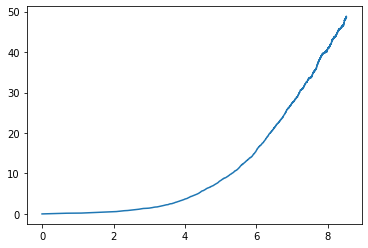

In [16]:
plot(log(arange(1,T+1)),avregret)